<a href="https://colab.research.google.com/github/jenner231/DLsolutions/blob/main/Lab4_1_Optimizer_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torch

from matplotlib.colors import LogNorm

# Intro

In this exercide you will work on optimizers: SGD, Adam, and RMSprop.
You will implement SGD by hand, and use Pytorch's optimizer for Adam and RMSProp.
The rest of this section will introduce a test function and plotting functions. Your task starts in section 2.

## Beale's function
Beale's is one among many nasty function often used for testing optimizers. We will used this function in this exercise.

### Global min of Baele's function

First of all, we're going to use Beale's function:

$$
f(x, y) =
(1.5 - x + xy)^2 +
(2.25 - x + xy^2)^2 +
(2.625 - x + xy^3)^2
$$

This is a [test function](https://en.wikipedia.org/wiki/Test_functions_for_optimization) for optimization. It's easy to show that its global minimum is at `(x, y) = (3., .5)`.

In [22]:
def f_beale(x, y):
    return (1.5 - x + x * y) ** 2 + (2.25 - x + x * y ** 2) ** 2 + (2.625 - x + x * y ** 3) ** 2

In [23]:
glob_min = (3., .5)
f_beale(*glob_min)

0.0

## Plotting 3D

Let's plot it in 3D. We use tutorial on 3d plotting from [here](https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html).

It's important to use logarithmic color normalization (see [here](https://matplotlib.org/stable/tutorials/colors/colormapnorms.html) and [here](https://stackoverflow.com/questions/17201172/a-logarithmic-colorbar-in-matplotlib-scatter-plot)):

> Objects that use colormaps by default linearly map the colors in the colormap from data values vmin to vmax. One of the most common transformations is to plot data by taking its logarithm (to the base-10). This transformation is useful to display changes across disparate scales.

In [24]:
lim, steps = 4.5, 45
x = np.linspace(-lim, lim, steps)
y = np.linspace(-lim, lim, steps)

X, Y = np.meshgrid(x, y)
Z = f_beale(X, Y)

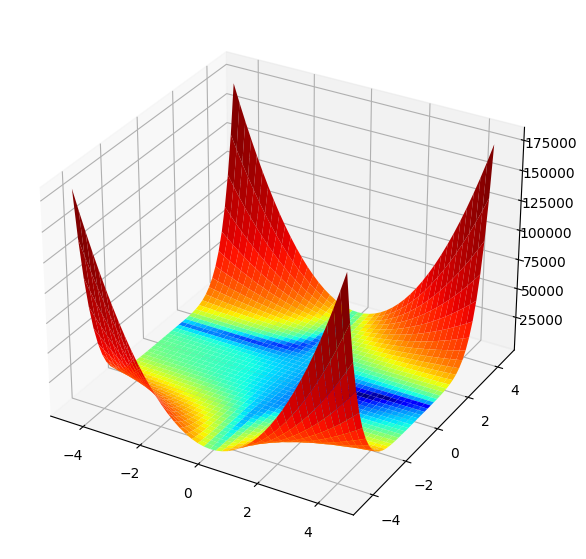

In [25]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, norm=LogNorm(), cmap=plt.cm.jet);

## Plotting 2D

We need 2 parameters here:
- `levels=np.logspace(0, 5, 35)`;
- `norm=LogNorm()`;

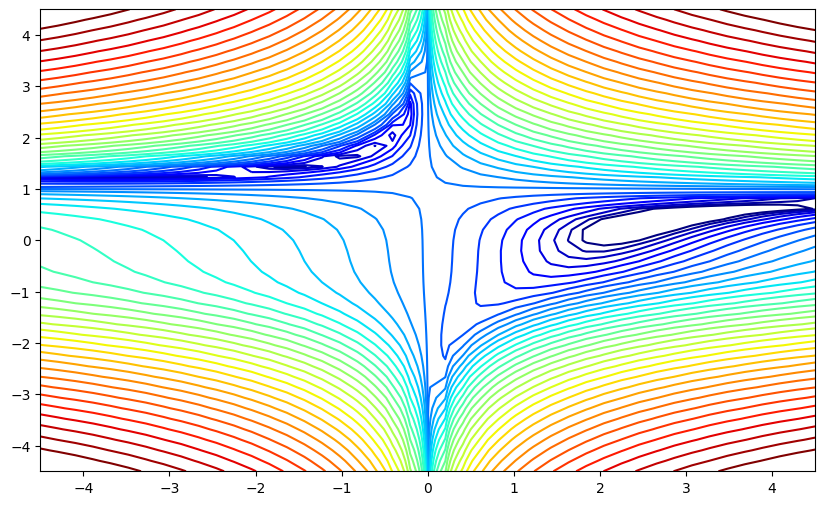

In [26]:
fig = plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet);

`np.logspace()` (see [here](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html)):

> Return numbers spaced evenly on a log scale.

# Gradient using `pytorch`

## Manual `SGD`

In this exercise, you should implement your own `SGD` optimizer. SGD updates are defined as:

$x := x-\nabla_x \cdot lr$

Please, fill in the code in the `WRITE CODE HERE` area to implement Stocastic Gradient Descent.

In [27]:
num_iter = 10000
learning_rate = 1e-4
eps = 1e-9

In [30]:
def find_min_SGD_manual(f=f_beale, num_iter=num_iter, lr=learning_rate, eps=eps, x_init=None):

    # If initial x is not given, initialize it
    if x_init is None:
        x = torch.tensor([3., 1.], requires_grad=True, dtype=torch.float32)
    else:
        x = x_init

    x_hist, y_hist = [], [] # save x and y history plotting purposes

    for i in range(num_iter):

        # Save history
        x_hist.append(x[0].detach().item())
        y_hist.append(x[1].detach().item())

        # Calculate loss
        loss = f(*x)

        # Stop when the loss is small
        if torch.abs(loss) < eps:
            return {'x':x,'iter':i,'loss':loss,'x_hist':x_hist,'y_hist':y_hist}
            break

        loss.backward()
        with torch.no_grad():

            # x := current value
            # lr := learning rate
            # x.grad := current gradient
            
            # WRITE CODE HERE
            # Update x using SGD
            x -= lr * x.grad
            # END WRITE CODE
            if x.grad is not None:
                x.grad.zero_()

        x.requires_grad = True

    return {'x':x,'iter':i,'loss':loss,'x_hist':x_hist,'y_hist':y_hist}


### Test the function with different learning rates

In [31]:
for lr in [1.5*1e-2, 1.25*1e-2, 1e-2, .75*1e-2, .5*1e-2]:
    res_manual = find_min_SGD_manual(lr=lr)
    print('x:',res_manual['x'],'iter:',res_manual['iter'],'loss:',res_manual['loss'])

x: tensor([2.9999, 0.5000], requires_grad=True) iter: 1745 loss: tensor(9.9707e-10, grad_fn=<AddBackward0>)
x: tensor([2.9999, 0.5000], requires_grad=True) iter: 2041 loss: tensor(9.9707e-10, grad_fn=<AddBackward0>)
x: tensor([2.9999, 0.5000], requires_grad=True) iter: 2398 loss: tensor(9.9877e-10, grad_fn=<AddBackward0>)
x: tensor([2.9999, 0.5000], requires_grad=True) iter: 2691 loss: tensor(9.9581e-10, grad_fn=<AddBackward0>)
x: tensor([3.0001, 0.5000], requires_grad=True) iter: 3515 loss: tensor(9.9905e-10, grad_fn=<AddBackward0>)


## Using `torch.optim`

If implemented correctly, you may see that the result of using `SGD` from `torch.optim` is the same.

In [32]:
num_iter = 10000
learning_rate = 1e-2
eps = 1e-9

In [33]:
def find_min_SGD_optim(f=f_beale, num_iter=num_iter, lr=learning_rate, eps=eps, x_init=None):

    # If initial x is not given, initialize it
    if x_init is None:
        x = torch.tensor([3., 1.], requires_grad=True, dtype=torch.float32)
    else:
        x = x_init

    x = torch.tensor([3., 1.], requires_grad=True, dtype=torch.float32)
    opt = optim.SGD([x], lr=lr)
    x_hist, y_hist = [], [] # save x and y history plotting purposes

    for i in range(num_iter):

        # Save history
        x_hist.append(x[0].detach().item())
        y_hist.append(x[1].detach().item())

        # Calculate loss
        loss = f(*x)
        if torch.abs(loss) < eps:
            return {'x':x,'iter':i,'loss':float(loss),'x_hist':x_hist,'y_hist':y_hist}
            break

        opt.zero_grad()
        loss.backward()
        opt.step()

    return {'x':x,'iter':i,'loss':float(loss),'x_hist':x_hist,'y_hist':y_hist}


In [34]:
res_optim = find_min_SGD_optim()
print('x:',res_optim['x'],'iter:',res_optim['iter'],'loss:',round(res_optim['loss'],5))

x: tensor([2.9999, 0.5000], requires_grad=True) iter: 2398 loss: 0.0


In [35]:
# Test that your implementation is correct
assert torch.dist(res_manual['x'], res_optim['x']) < 0.001

## Plotting `SGD`

Can we somehow plot it on the contours of our function?

In [36]:
# Initial parameters
x = torch.tensor([1., -2.], requires_grad=True, dtype=torch.float32)

# run uptimizer
res = find_min_SGD_manual(lr=1e-3, num_iter=100000, eps=1e-7, x_init=x)

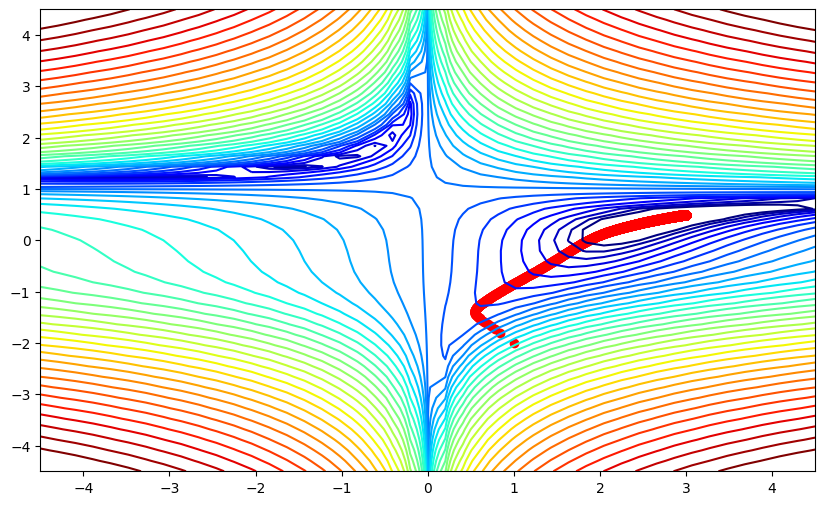

In [37]:
fig = plt.figure(figsize=(10, 6))
plt.plot(res['x_hist'], res['y_hist'], 'ro')
plt.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet);

## Other update rules

Let's consider a couple more update rules.

Please fill in `WRITE CODE HERE` blocks, so that the function  supports `SGD`, `SGD` with momentum, `RMSprop` and `Adam`. You can use the implementation from [Pytorch optim](https://pytorch.org/docs/stable/optim.html).

In [40]:
def find_min_optim_multi(f=f_beale, num_iter=10000, lr=1e-2, eps=1e-5, opt='sgd', x_init=None):

    # If initial x is not given, initialize it
    if x_init is None:
        x = torch.tensor([1., -2.], requires_grad=True, dtype=torch.float32)
    else:
        x = x_init

    x_hist, y_hist = [], []

    if opt == 'sgd':
        # WRITE CODE HERE
        opt = torch.optim.SGD([x], lr=lr)
        # END WRITE CODE

    elif opt == 'sgdm':
        # WRITE CODE HERE
        opt = torch.optim.SGD([x], lr=lr, momentum=0.9)
        # END WRITE CODE

    elif opt == 'rms':
        # WRITE CODE HERE
        opt = torch.optim.RMSprop([x], lr=lr)
        # END WRITE CODE

    elif opt== 'adam':
        # WRITE CODE HERE
        opt = torch.optim.Adam([x], lr=lr)
        # END WRITE CODE


    for i in range(num_iter):

        x_hist.append(x[0].detach().item())
        y_hist.append(x[1].detach().item())

        loss = f(*x)
        if torch.abs(loss) < eps:
            #print(f'lr:{lr} i:{i} loss:{loss:.9f}')
            #return x_hist, y_hist
            return {'x':x,'iter':i,'loss':float(loss),'x_hist':x_hist,'y_hist':y_hist}
            break

        opt.zero_grad()
        loss.backward()
        opt.step()

    #print(f'lr:{lr} i:{i} loss:{loss:.9f}')
    return {'x':x,'iter':i,'loss':float(loss),'x_hist':x_hist,'y_hist':y_hist}

In [41]:
for opt in ['sgd', 'sgdm', 'rms', 'adam']:
    print(f'==========opt:{opt}==========')
    for lr in [1e-4, 1e-3, 1e-2, 1e-1]:
        res = find_min_optim_multi(lr=lr, opt=opt)
        print('lr:',lr,'iter:',res['iter'],'loss:',round(res['loss'],5))
    print()

==========opt:sgd==========
lr: 0.0001 iter: 9999 loss: 0.18278
lr: 0.001 iter: 9999 loss: 7e-05
lr: 0.01 iter: 1283 loss: 1e-05
lr: 0.1 iter: 9999 loss: nan

==========opt:sgdm==========
lr: 0.0001 iter: 9999 loss: 6e-05
lr: 0.001 iter: 1227 loss: 1e-05
lr: 0.01 iter: 9999 loss: nan
lr: 0.1 iter: 9999 loss: nan

==========opt:rms==========
lr: 0.0001 iter: 9999 loss: 5.90723
lr: 0.001 iter: 4068 loss: 1e-05
lr: 0.01 iter: 1121 loss: 1e-05
lr: 0.1 iter: 9999 loss: 0.07525

==========opt:adam==========
lr: 0.0001 iter: 9999 loss: 8.15168
lr: 0.001 iter: 9999 loss: 0.00788
lr: 0.01 iter: 5156 loss: 1e-05
lr: 0.1 iter: 1032 loss: 1e-05



In [42]:
x_init = torch.tensor([1., -2.], requires_grad=True, dtype=torch.float32)
res_sgd = find_min_optim_multi(opt='sgd', lr=1e-2, x_init=x_init)

x_init = torch.tensor([1., -2.], requires_grad=True, dtype=torch.float32)
res_sgdm = find_min_optim_multi(opt='sgdm', lr=1e-3, x_init=x_init)

x_init = torch.tensor([1., -2.], requires_grad=True, dtype=torch.float32)
res_rms = find_min_optim_multi(opt='rms', lr=1e-2, x_init=x_init)

x_init = torch.tensor([1., -2.], requires_grad=True, dtype=torch.float32)
res_adam = find_min_optim_multi(opt='adam', lr=1e-1, x_init=x_init)

## Let's plot the results from the four optimizers

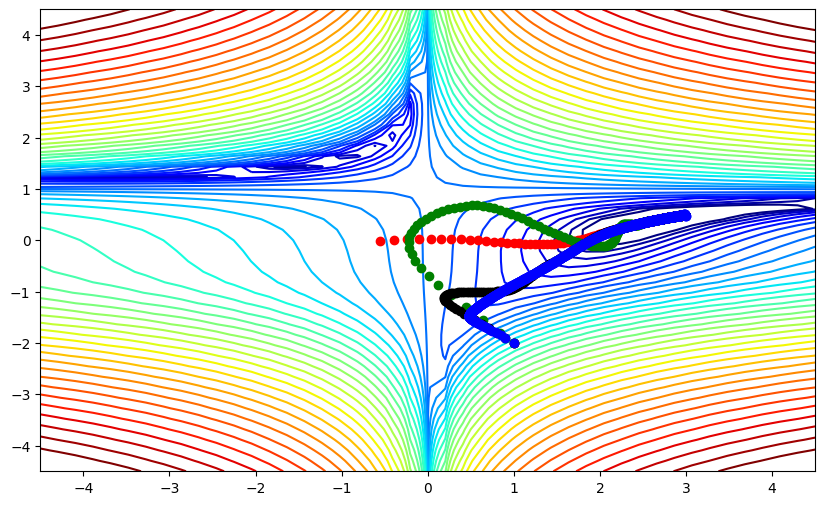

In [43]:
fig = plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)

plt.plot(res_sgd['x_hist'], res_sgd['y_hist'], 'ro')
plt.plot(res_sgdm['x_hist'], res_sgdm['y_hist'], 'go')
plt.plot(res_adam['x_hist'], res_adam['y_hist'], 'ko');
plt.plot(res_rms['x_hist'], res_rms['y_hist'], 'bo');
